# COMP4167 Natural Language Processing
# Practical I - Part I
# Tokenization, Term-Document Matrix, TF-IDF and Text classification

In this notebook you will practice some of the methods discusssed in the lectures to address an NLP task, text classification.

In this notebook you will:
- Perform the process of tokenization
- Build a Term-Document Matrix (using some methods like Counting words and TFIDF) as the feature extraction method
- Apply a machine learning classifier to predict or classify a tweet as real or fake.

## Problem Description
Emergency agencies started using social media and especially Twitter to identify quickly when disasters are hppening. In this problem,you’re tasked to build a machine learning model that predicts which Tweets are related to real disaster and which are not relevant. The dataset has 10,000 tweets that were manually classified.

This is a [Kaggle competition](https://www.kaggle.com/c/nlp-getting-started) to getting started in NLP.

## Importing the libraries

- make sure the libraries are already installed using pip or conda
- install the latest version of the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_auc_score,roc_curve,auc,f1_score

## Setup the data for pre-processing 

Data are assumed to be in the 'data' folder which includes two files:
- `train.csv`: the training data set
- `test.csv`: the testing data set

In [2]:
data_folder_name = 'data'
train_filename = 'train.csv'

train_path = data_folder_name +'/'+ train_filename 

# Relevant columns for this exercise 
TEXT_COLUMN = 'text'
TARGET_COLUMN = 'target'

### Loading the datasets

Each sample in the train and test set has the following information:

- The text of a tweet
- A keyword from that tweet (although this may be blank!)
- The location the tweet was sent from (may also be blank)

The task is to predict whether a given tweet is about a real disaster (1) or not (0).

In [3]:
# Read the tweets of the train dataset
# we will use this data for the training by spliting it into further training and validation set
data = pd.read_csv(train_path)

In [4]:
# Sample some data from the training set
# re-running the cell will produce another sample
data.sample(10)

,id,keyword,location,text,target
6675,9566,thunder,"Decatur, GA",@KristyLeeMusic brings her Alabama thunder bac...,0
7044,10091,typhoon,"Washington, DC",Massive Typhoon heads toward Taiwan. http://t....,1
5996,8561,screams,POFFIN,in every bts song jimin screams,0
4889,6961,massacre,NaN,@KabarMesir @badr58 \nNever dies a big Crime l...,1
5661,8074,rescue,NaN,Sammy and todd always to the rescue may not be...,0
1489,2146,catastrophe,Ylisse,@MasochisticMage + catastrophe! It caused peop...,0
2453,3521,derailment,NaN,@greateranglia I know the cow incident not yr ...,1
3853,5482,flames,St. Patrick's Purgatory,@TadhgTGMTEL dude was just smoking and the fuc...,1
498,721,attacked,Peshawar,IK Only Troll His Pol Rivals Never Literally A...,0
2553,3661,destroy,NaN,@RaidersReporter @957thegame together we can d...,0


In [5]:
# Extract only the text and target columns from our dataframe, 
# for this exercise we will assume the other fields are not important
data = data[[TEXT_COLUMN, TARGET_COLUMN]]

In [6]:
# sample 10 strings of class 1 (disaster)
list(data[data['target']==1].sample(10)['text'])

['Heavy rain frequent thunder and gusty winds moving into parts of Uptown and Midtown. http://t.co/KQJevYqzLV - CN http://t.co/HmWhob7prs',
 'INEC Office in Abia Set Ablaze - http://t.co/3ImaomknnA',
 'Flooding kills 166 displace over one million in Pakistan - Daily News &amp; Analysis http://t.co/KkOOVBKndp',
 '80 @UChicago faculty members pushing university to overturn ban of trauma center protesters http://t.co/ta1yqclpSc http://t.co/xToHI1HexY',
 'Rare insight into #terror and How to fight it http://t.co/t6OBVWaPhW #Cameroon #USA #Whitehouse #ES #FR #Nigeria #UK #Africa #DE #CA #AU #JP',
 'ARA news reporting JaN fighters infiltrated Ashrafiyah district of Afrin with aim of carrying out suicide attacks. YPG have imposed a curfew',
 "Australia's Ashes disaster - how the collapse unfolded at Trent Bridge... http://t.co/Dq3ddGvgBF\n #cricket",
 'Make man pikin crash ??????',
 "NWS says thunderstorms with deadly lightning will move across the Black Hills this evening. That assumes there

In [7]:
# sample 10 strings of class 0 (not a disaster)
list(data[data['target']==0].sample(10)['text'])

["@spookyfob @feelslikefob I am okay thank you yes your kindness is fatal though it's like Patrick stump level kindness.",
 'The number of people denying climate change on the polar bear article makes me fear for the future of the US but also humanity in general.',
 'I need to plan a trip to Cleveland soon! ??',
 '@CarsonRex @SpaceAngelSeven Check out this #rockin preview of @ClaytonBryant Danger Zone Coming soon! https://t.co/P0fiZxmN5r #ArtistsUnited',
 'Homemade frozen yogurt pops? Have you had luck making them? http://t.co/YzaZF4CEOa http://t.co/X5RC5Nuamh',
 '@RaidersReporter @957thegame together we can destroy the Emperor and rule the galaxy Father and Son!',
 '(OFFICIAL VID) &gt; #DoubleCups &gt;&gt; https://t.co/lfKMTZaEkk &gt;&gt; @TrubGME Prod @THISIZBWRIGHT &gt;&gt; #ARMAGEDDON                 .',
 "MotoGP Indianapolis: Espargaro: Layout 'worries me a little' - http://t.co/RNy4l3sr7a http://t.co/igX8XFz8Ko",
 "in fact if y'all could tag like small creeping or self inflicted 

### Splitting the dataset into train and test set

We split the train dataset into a train and validation dataset so we can evaluate the result with cross-validation. 
- we use 80-20 data split
- set the random_state which help re-producing the same results every time we run the code

In [8]:
X_train, X_val, y_train, y_val = train_test_split(data[TEXT_COLUMN], 
                                                  data[TARGET_COLUMN].values,
                                                  test_size=0.20,
                                                  random_state=0)
# check the size of our datasets
print('Size of training set:',X_train.shape)
print('Size of validation set:',X_val.shape)

Size of training set: (6090,)
Size of validation set: (1523,)


# Feature extraction

In this exercise we will extract TF/IDF features.
- We will use the implmentation of TF/IDF in scikit-learn
- In the implmentation we will use lower case 
- We will drop the words that occured less than two times in the documents
- The TF/IDF vectorizer is built on the training data and is then used to extract features from both training and validation sets 

In [9]:
# Try multiple ways of calculating features.
#   Create the numericalizer TFIDF for lowercase
tfidf = TfidfVectorizer(decode_error='ignore', lowercase=True, min_df=2)
#   Numericalize the train dataset
train = tfidf.fit_transform(X_train.values.astype('U'))
#   Numericalize the test dataset
val = tfidf.transform(X_val.values.astype('U'))

In [10]:
print('Train size: ',train.shape)
print('Val size: ',val.shape)

Train size:  (6090, 5671)
Val size:  (1523, 5671)


### Sample some words from the dictionary

In [11]:
dictionary = np.asarray(tfidf.get_feature_names_out())
print(dictionary[np.random.randint(0,len(dictionary),size=20)])

['total' 'forth' 'every' 'billneelynbc' 'dm' 'brave' 'hopefully' 'town'
 'slayer' 'makes' '100' 'panicking' 'hmm' 'poor' 'progress' 'piece' 'mile'
 'put' 'find' 'firetruck']


## Train the models

The extracted features will be used to train classifiers in to order to predict which tweets belong to class 0 or class 1.

We will test here three classifiers: 
- Naive Bayes
- SVM
- XBGboost Classifier

### Naive Bayes

One of the most commonly used classifier for text classification: Naive Bayes using multinomial models. 
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [12]:
# create the model, train it on the train dataset and print the scores
model = MultinomialNB() # as implemented in sklearn
model.fit(train, y_train)
print("Train score:", model.score(train, y_train))
print("Validation score:", model.score(val, y_val))

Train score: 0.8596059113300493
Validation score: 0.7964543663821405


#### Evaluate the Naive Bayes classifier
First we create some helper functions to plot the results:

In [13]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10}) # font size
    plt.show()

In [15]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

              precision    recall  f1-score   support

           0       0.78      0.91      0.84       886
           1       0.83      0.64      0.72       637

    accuracy                           0.80      1523
   macro avg       0.81      0.77      0.78      1523
weighted avg       0.80      0.80      0.79      1523



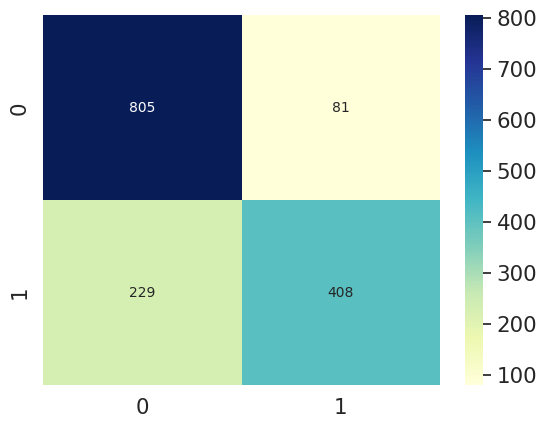

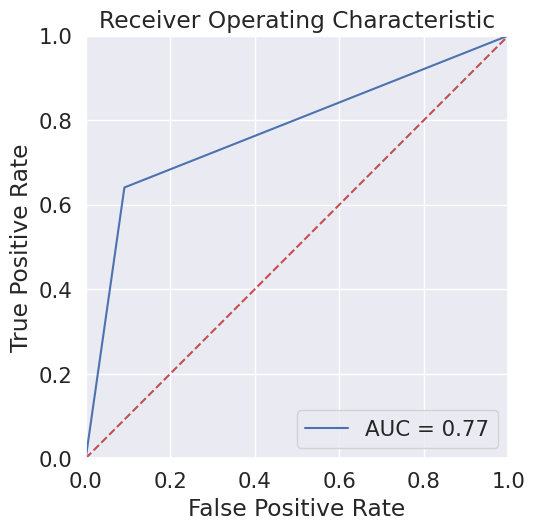

In [16]:
# Predicting the Test set results
y_pred = model.predict(val)

#print the classification report to highlight the accuracy with f1-score, precision and recall
print(metrics.classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)
plot_roc_curve(y_val, y_pred)

### Suport Vector Machine Classifier
Alternatively, we can use SVM algorithm to predict if a tweet is fake or real, it is just a binary classifcation problem. 
For SVM it is important to optimise the parameters of the kernel used. Here we use a GridSearch to optimise the hyper paramters of an RBF Kernel. A similar process can be done for other kernels like Linear or Gaussian.

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Define the parameters to tune
parameters = { 
    'C': [1.0, 10],
    'gamma': [1, 'auto', 'scale']
}
# Tune hyperparameters  using Grid Search and a SVM model
model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)

Once our model is trained we can evaluate the performance as we did previously:

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       886
           1       0.87      0.66      0.75       637

    accuracy                           0.81      1523
   macro avg       0.83      0.79      0.80      1523
weighted avg       0.82      0.81      0.81      1523



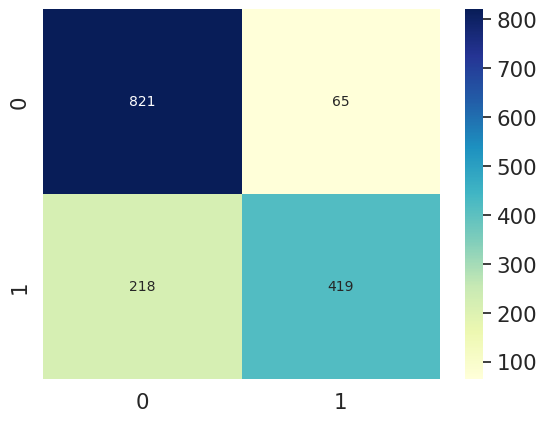

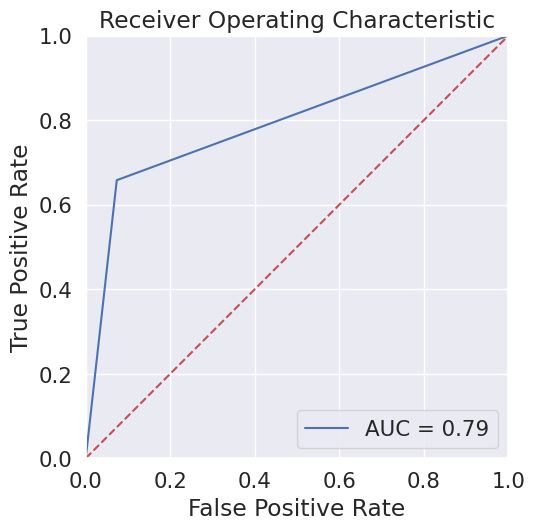

In [18]:
# Predicting the validation set 
y_pred = model.predict(val)

print(metrics.classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)
plot_roc_curve(y_val, y_pred)

This simple SVM increases the performance of our model but not significantly.

### XGBoost classifier

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance. XGBoost is an advanced version of gradient boosting. Rather than training all of the models in isolation of one another, boosting trains models in succession, with each new model being trained to correct the errors made by the previous ones. Models are added sequentially until no further improvements can be made.

XGBoost provides a wrapper class to allow any models to be treated like classifiers or regressors in the scikit-learn framework. This means we can use the full scikit-learn library with XGBoost models.

In [19]:
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score


def f1_metric(ytrue,preds):
    ''' Return the F1 Score value for the preds and true values, ytrue '''
    return 'f1_score', f1_score((preds>=0.5).astype('int'), ytrue, average='macro'), True

# set the model parameters
params = {
    'learning_rate': 0.06,
    'n_estimators': 1500,
    'colsample_bytree': 0.5,
    'metric': 'f1_score'
}

full_clf = LGBMClassifier(**params)

# Fit or train the xgboost model
full_clf.fit(train.astype(np.float32), y_train, eval_set=[(train.astype(np.float32), y_train), (val.astype(np.float32), y_val)],
             verbose=400, eval_metric=f1_metric)

#Show the results
print("train score:", full_clf.score(train.astype(np.float32), y_train))
print("val score:", full_clf.score(val.astype(np.float32), y_val))

/home/thomas/Documents/nlp-workshops/env/lib/python3.10/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[400]	valid_0's f1_score: 0.925268	valid_1's f1_score: 0.769685
[800]	valid_0's f1_score: 0.965384	valid_1's f1_score: 0.767301
[1200]	valid_0's f1_score: 0.978371	valid_1's f1_score: 0.758864
train score: 0.9809523809523809
val score: 0.7688772160210111


Now, we can predict on the test dataset to get the results and compare with others methods.

              precision    recall  f1-score   support

           0       0.79      0.93      0.85       886
           1       0.87      0.66      0.75       637

    accuracy                           0.81      1523
   macro avg       0.83      0.79      0.80      1523
weighted avg       0.82      0.81      0.81      1523



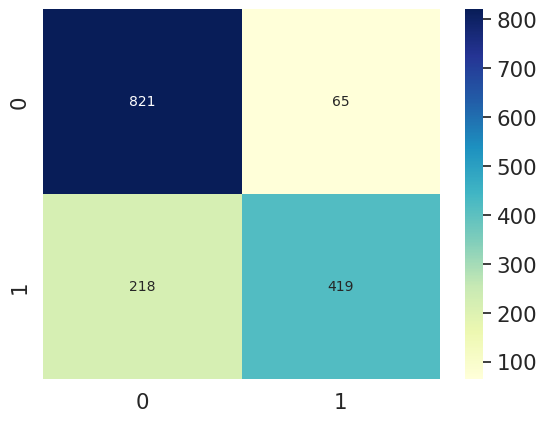

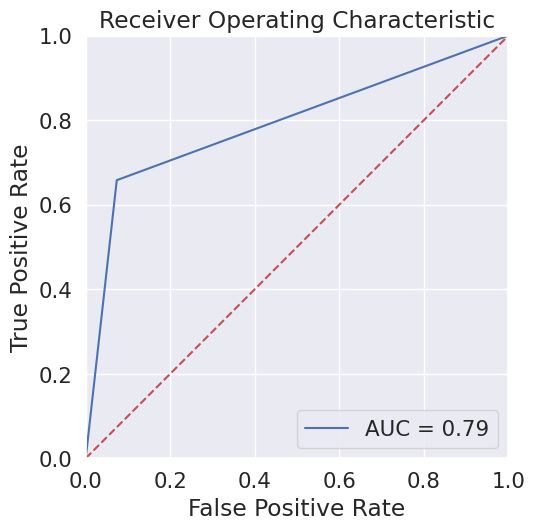

In [21]:
# Predicting the Test set results
Y_pred = full_clf.predict(val.astype(np.float32))

print(metrics.classification_report(y_val, y_pred))
plot_confusion_matrix(y_val, y_pred)
plot_roc_curve(y_val, y_pred)

## Visualize some results from our text

Another tool we can use to analyze the results is a WordCloud where we can draw the most relevant words in the fake tweets and real tweets. 

In [23]:
# visualize the data on a WordCloud
from wordcloud import WordCloud

def visualize(label):
    words = ''
    for msg in data[data[TARGET_COLUMN] == label][TEXT_COLUMN]:
        msg = msg.lower()
        words += msg + ' '
    wordcloud = WordCloud(width=600, height=600).generate(words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

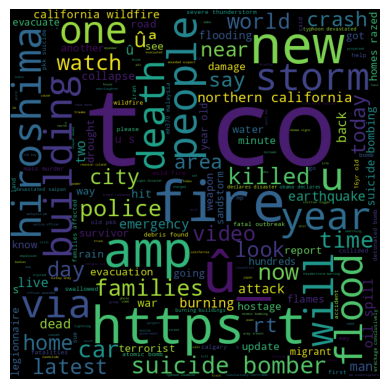

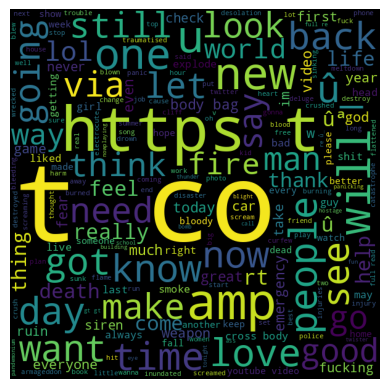

In [24]:
visualize(1)
visualize(0)